In [1]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
from sklearn.metrics import classification_report, confusion_matrix

In [2]:
# 디바이스 설정
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
# 데이터 경로
base_dir = "/home/ec2-user/SageMaker/data/Binary_PNG"

In [4]:
# 데이터 전처리
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(15),
        transforms.ColorJitter(brightness=0.2, contrast=0.2),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
}

# DataLoader 설정
dataloaders = {
    x: DataLoader(
        datasets.ImageFolder(root=os.path.join(base_dir, x), transform=data_transforms[x]),
        batch_size=32, shuffle=(x == 'train'), num_workers=4
    )
    for x in ['train', 'val', 'test']
}

dataset_sizes = {x: len(dataloaders[x].dataset) for x in ['train', 'val', 'test']}
class_names = dataloaders['train'].dataset.classes

print(f"Classes: {class_names}")
print(f"Dataset sizes: {dataset_sizes}")

Classes: ['NG', 'OK']
Dataset sizes: {'train': 3977, 'val': 1136, 'test': 570}


In [3]:
# Pre-trained ResNet-18 모델 불러오기
model = models.resnet18(pretrained=True)
num_features = model.fc.in_features
model.fc = nn.Sequential(
    nn.Linear(num_features, 1),
    nn.Sigmoid()
)
model = model.to(device)

# 손실 함수와 옵티마이저 설정
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Early Stopping 설정
early_stopping_patience = 5
best_val_loss = float('inf')
no_improvement_epochs = 0

NameError: name 'models' is not defined

In [6]:
def train_model_with_early_stopping(model, criterion, optimizer, dataloaders, dataset_sizes, num_epochs=13, patience=5):
    # Early Stopping 변수 초기화
    best_val_loss = float('inf')  # 초기 Best Validation Loss
    no_improvement_epochs = 0     # 개선되지 않은 에폭 수
    best_model_wts = model.state_dict()  # Best 모델 가중치 저장
    best_acc = 0.0  # Best Validation Accuracy

    for epoch in range(num_epochs):
        print(f"Epoch {epoch + 1}/{num_epochs}")
        print("-" * 20)

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device).float()

                # Forward pass
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs).squeeze(1)
                    preds = (outputs > 0.5).float()
                    loss = criterion(outputs, labels)

                    if phase == 'train':
                        optimizer.zero_grad()
                        loss.backward()
                        optimizer.step()

                # Loss 및 정확도 계산
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print(f"{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}")

            # Best 모델 저장 및 Early Stopping 확인
            if phase == 'val':
                if epoch_loss < best_val_loss:
                    best_val_loss = epoch_loss
                    best_model_wts = model.state_dict()
                    no_improvement_epochs = 0
                else:
                    no_improvement_epochs += 1

        # Early Stopping 조건
        if no_improvement_epochs >= patience:
            print("Early stopping triggered. Training stopped.")
            break

    # Best 모델 가중치 로드
    model.load_state_dict(best_model_wts)
    print(f"Best Validation Loss: {best_val_loss:.4f}")
    return model



In [7]:
def evaluate_model(model, dataloader):
    model.eval()
    y_true = []
    y_pred = []

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device).float()

            # Forward pass
            outputs = model(inputs).squeeze(1)
            preds = (outputs > 0.5).float()

            # 결과 저장
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())

    print("Confusion Matrix:")
    print(confusion_matrix(y_true, y_pred))

    print("\nClassification Report:")
    print(classification_report(y_true, y_pred, target_names=class_names))


In [ ]:
# 모델 학습: num_epochs를 13으로 설정
model = train_model_with_early_stopping(model, criterion, optimizer, dataloaders, dataset_sizes, num_epochs=13, patience=5)

Epoch 1/13
--------------------
train Loss: 0.2118 Acc: 0.9273
val Loss: 0.2570 Acc: 0.9340
Epoch 2/13
--------------------
train Loss: 0.1370 Acc: 0.9573
val Loss: 0.0979 Acc: 0.9639
Epoch 3/13
--------------------
train Loss: 0.1227 Acc: 0.9603
val Loss: 0.1642 Acc: 0.9736
Epoch 4/13
--------------------
train Loss: 0.1084 Acc: 0.9645
val Loss: 0.1168 Acc: 0.9577
Epoch 5/13
--------------------
train Loss: 0.1032 Acc: 0.9678
val Loss: 0.3110 Acc: 0.9269
Epoch 6/13
--------------------
train Loss: 0.0800 Acc: 0.9746
val Loss: 0.0540 Acc: 0.9842
Epoch 7/13
--------------------
train Loss: 0.0736 Acc: 0.9774
val Loss: 0.0643 Acc: 0.9762
Epoch 8/13
--------------------
train Loss: 0.1149 Acc: 0.9618
val Loss: 0.0960 Acc: 0.9674
Epoch 9/13
--------------------
train Loss: 0.0736 Acc: 0.9794
val Loss: 0.0681 Acc: 0.9798
Epoch 10/13
--------------------
train Loss: 0.0777 Acc: 0.9746
val Loss: 0.0734 Acc: 0.9754
Epoch 11/13
--------------------
train Loss: 0.0672 Acc: 0.9814
val Loss: 0.105

In [ ]:
# 테스트 데이터 평가
print("\nTesting the model...")
evaluate_model(model, dataloaders['test'])


Testing the model...
Confusion Matrix:
[[130   1]
 [  7 432]]

Classification Report:
              precision    recall  f1-score   support

          NG       0.95      0.99      0.97       131
          OK       1.00      0.98      0.99       439

    accuracy                           0.99       570
   macro avg       0.97      0.99      0.98       570
weighted avg       0.99      0.99      0.99       570



In [ ]:
import time
from sklearn.metrics import classification_report, confusion_matrix, f1_score

def evaluate_model(model, dataloader):
    model.eval()
    y_true = []
    y_pred = []

    # 추론 시간 측정 시작
    start_time = time.time()

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device).float()

            # Forward pass
            outputs = model(inputs).squeeze(1)  # 출력 차원 조정 (필요 시)
            preds = (outputs > 0.5).float()

            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())

    # 추론 시간 측정 종료
    end_time = time.time()
    inference_time = end_time - start_time

    # Confusion Matrix
    print("Confusion Matrix:")
    print(confusion_matrix(y_true, y_pred))

    # Classification Report
    print("\nClassification Report:")
    print(classification_report(y_true, y_pred, target_names=class_names))

    # F1-score 점수 출력
    f1 = f1_score(y_true, y_pred, average="weighted")
    print(f"\nWeighted F1-score: {f1:.4f}")

    # 추론 시간 출력
    print(f"\nInference Time (Total): {inference_time:.4f} seconds")
    print(f"Average Inference Time per Sample: {inference_time / len(y_true):.4f} seconds")

# 테스트 데이터 평가
evaluate_model(model, dataloaders['test'])


Confusion Matrix:
[[130   1]
 [  7 432]]

Classification Report:
              precision    recall  f1-score   support

          NG       0.95      0.99      0.97       131
          OK       1.00      0.98      0.99       439

    accuracy                           0.99       570
   macro avg       0.97      0.99      0.98       570
weighted avg       0.99      0.99      0.99       570


Weighted F1-score: 0.9861

Inference Time (Total): 16.5807 seconds
Average Inference Time per Sample: 0.0291 seconds


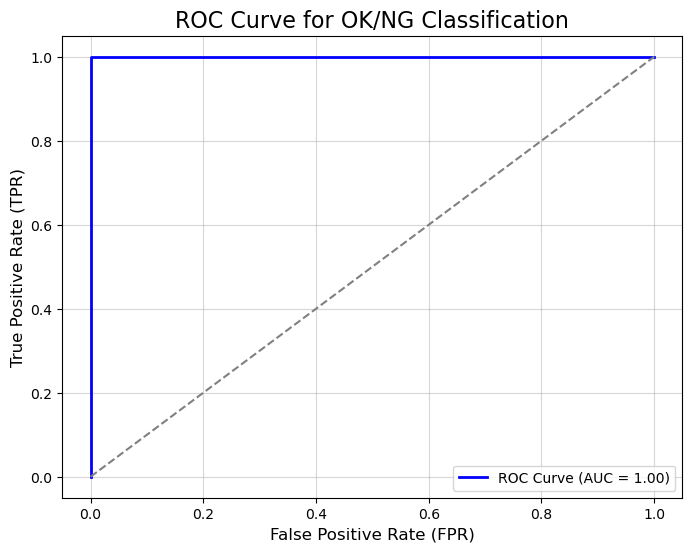

In [15]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# OK/NG 데이터 샘플링
ok_images = [
    "/home/ec2-user/SageMaker/data/Binary_PNG/train/OK/0.png",
    "/home/ec2-user/SageMaker/data/Binary_PNG/train/OK/1.png"
]
ng_images = [
    "/home/ec2-user/SageMaker/data/Binary_PNG/train/NG/1027.png",
    "/home/ec2-user/SageMaker/data/Binary_PNG/train/NG/1028.png"
]

# ROC 계산 함수
def compute_roc_for_images(model, image_paths, true_label):
    """
    Calculate ROC data for specific images.
    Args:
        model: Trained PyTorch model
        image_paths: List of image paths to evaluate
        true_label: Ground truth label (0 for OK, 1 for NG)
    Returns:
        y_true: List of true labels
        y_scores: List of predicted scores
    """
    y_true = []
    y_scores = []

    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

    for img_path in image_paths:
        # 이미지 불러오기
        img = datasets.folder.default_loader(img_path)  # PIL.Image로 로드
        img = transform(img).unsqueeze(0).to(device)  # 모델 입력 형태로 변환

        # 추론 수행
        with torch.no_grad():
            output = torch.sigmoid(model(img)).squeeze(1).cpu().numpy()  # 확률 값으로 변환
            y_scores.append(output[0])  # 첫 번째 출력 값 저장
            y_true.append(true_label)

    return y_true, y_scores

# OK/NG 클래스에 대한 ROC 데이터 생성
y_true_ok, y_scores_ok = compute_roc_for_images(model, ok_images, true_label=1)  # OK 클래스
y_true_ng, y_scores_ng = compute_roc_for_images(model, ng_images, true_label=0)  # NG 클래스

# ROC 데이터 병합
y_true = y_true_ok + y_true_ng
y_scores = y_scores_ok + y_scores_ng

# ROC Curve 및 AUC 계산
fpr, tpr, thresholds = roc_curve(y_true, y_scores)
roc_auc = auc(fpr, tpr)

# ROC Curve 시각화
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f"ROC Curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Random classifier line
plt.title("ROC Curve for OK/NG Classification", fontsize=16)
plt.xlabel("False Positive Rate (FPR)", fontsize=12)
plt.ylabel("True Positive Rate (TPR)", fontsize=12)
plt.legend(loc="lower right")
plt.grid(alpha=0.5)
plt.show()

In [12]:
print("y_true:", y_true)
print("y_scores:", y_scores)


y_true: [0, 0, 1, 1]
y_scores: [0.9332991, 0.9338347, 0.0040428573, 0.004588276]


In [14]:
from torchvision import datasets

# ImageFolder 로드
dataset_dir = "/home/ec2-user/SageMaker/data/Binary_PNG/train"
dataset = datasets.ImageFolder(root=dataset_dir)

# 클래스 이름과 라벨 매핑 출력
print("Class-to-Index Mapping:", dataset.class_to_idx)

# 데이터 예제 확인
for img, label in dataset.samples[:10]:  # 처음 10개의 샘플 출력
    print(f"Image: {img}, Label: {label}")


Class-to-Index Mapping: {'NG': 0, 'OK': 1}
Image: /home/ec2-user/SageMaker/data/Binary_PNG/train/NG/1027.png, Label: 0
Image: /home/ec2-user/SageMaker/data/Binary_PNG/train/NG/1027_f.png, Label: 0
Image: /home/ec2-user/SageMaker/data/Binary_PNG/train/NG/1027_flipped_lr_84.png, Label: 0
Image: /home/ec2-user/SageMaker/data/Binary_PNG/train/NG/1027_flipped_ud_83.png, Label: 0
Image: /home/ec2-user/SageMaker/data/Binary_PNG/train/NG/1027_gbr.png, Label: 0
Image: /home/ec2-user/SageMaker/data/Binary_PNG/train/NG/1027_gnrgb.png, Label: 0
Image: /home/ec2-user/SageMaker/data/Binary_PNG/train/NG/1027_rotated180_81.png, Label: 0
Image: /home/ec2-user/SageMaker/data/Binary_PNG/train/NG/1027_rotated270_82.png, Label: 0
Image: /home/ec2-user/SageMaker/data/Binary_PNG/train/NG/1027_rotated90_80.png, Label: 0
Image: /home/ec2-user/SageMaker/data/Binary_PNG/train/NG/1028.png, Label: 0


In [4]:
def visualize_predictions(model, image_paths, class_names):
    """
    Visualize predictions for a list of image paths.
    
    Args:
        model: Trained PyTorch model
        image_paths: List of image paths to visualize
        class_names: List of class names (e.g., ["OK", "NG"])
    """
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

    model.eval()  # Set the model to evaluation mode

    plt.figure(figsize=(15, 10))
    
    for idx, image_path in enumerate(image_paths):
        # Load and preprocess the image
        img = Image.open(image_path).convert('RGB')
        input_tensor = transform(img).unsqueeze(0).to(device)
        
        # Perform prediction
        with torch.no_grad():
            output = model(input_tensor)
            prob = torch.sigmoid(output).item()  # Convert to probability
            predicted_label = 1 if prob > 0.5 else 0
        
        # Plot the image with the prediction
        plt.subplot(1, len(image_paths), idx + 1)
        plt.imshow(img)
        plt.axis("off")
        plt.title(f"Prediction: {class_names[predicted_label]}\nConfidence: {prob:.2f}")
    
    plt.tight_layout()
    plt.show()


In [5]:
# 이미지 경로 리스트
image_paths = [
    "/home/ec2-user/SageMaker/data/Binary_PNG/test/OK/1034.png",
    "/home/ec2-user/SageMaker/data/Binary_PNG/test/NG/1196.png"
]

# 클래스 이름 (0: OK, 1: NG)
class_names = ["NG", "OK"]

# ResNet18 모델 시각화
visualize_predictions(model, image_paths, class_names)


NameError: name 'model' is not defined

In [6]:
pwd

'/home/ec2-user/SageMaker/yujin'

In [7]:
import torch
import torch.nn as nn
from torchvision import models

# 디바이스 설정
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ResNet18 모델 정의
model = models.resnet18(pretrained=False)  # 사전 학습된 모델을 사용하지 않음 (가중치 파일을 로드할 예정)
num_features = model.fc.in_features  # ResNet18의 마지막 레이어 입력 크기
model.fc = nn.Sequential(
    nn.Linear(num_features, 1),  # 이진 분류를 위한 출력 크기 1
    nn.Sigmoid()  # Sigmoid 활성화 함수
)

# 모델을 디바이스에 로드
model = model.to(device)

# 사전 학습된 가중치 로드
weights_path = "/home/ec2-user/SageMaker/sein/model/resnet18/best_model.pth"
model.load_state_dict(torch.load(weights_path, map_location=device))

# 모델을 평가 모드로 설정
model.eval()

print("Model loaded successfully!")


/home/ec2-user/anaconda3/envs/pytorch_p310/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/ec2-user/anaconda3/envs/pytorch_p310/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Model loaded successfully!


In [8]:
import matplotlib.pyplot as plt
from torchvision import transforms
from PIL import Image

def visualize_predictions(model, image_paths, class_names):
    """
    Visualize predictions for a list of image paths.
    
    Args:
        model: Trained PyTorch model
        image_paths: List of image paths to visualize
        class_names: List of class names (e.g., ["OK", "NG"])
    """
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

    plt.figure(figsize=(15, 10))
    
    for idx, image_path in enumerate(image_paths):
        # Load and preprocess the image
        img = Image.open(image_path).convert('RGB')
        input_tensor = transform(img).unsqueeze(0).to(device)
        
        # Perform prediction
        with torch.no_grad():
            output = model(input_tensor)
            prob = torch.sigmoid(output).item()  # Convert to probability
            predicted_label = 1 if prob > 0.5 else 0
        
        # Plot the image with the prediction
        plt.subplot(1, len(image_paths), idx + 1)
        plt.imshow(img)
        plt.axis("off")
        plt.title(f"Prediction: {class_names[predicted_label]}\nConfidence: {prob:.2f}")
    
    plt.tight_layout()
    plt.show()


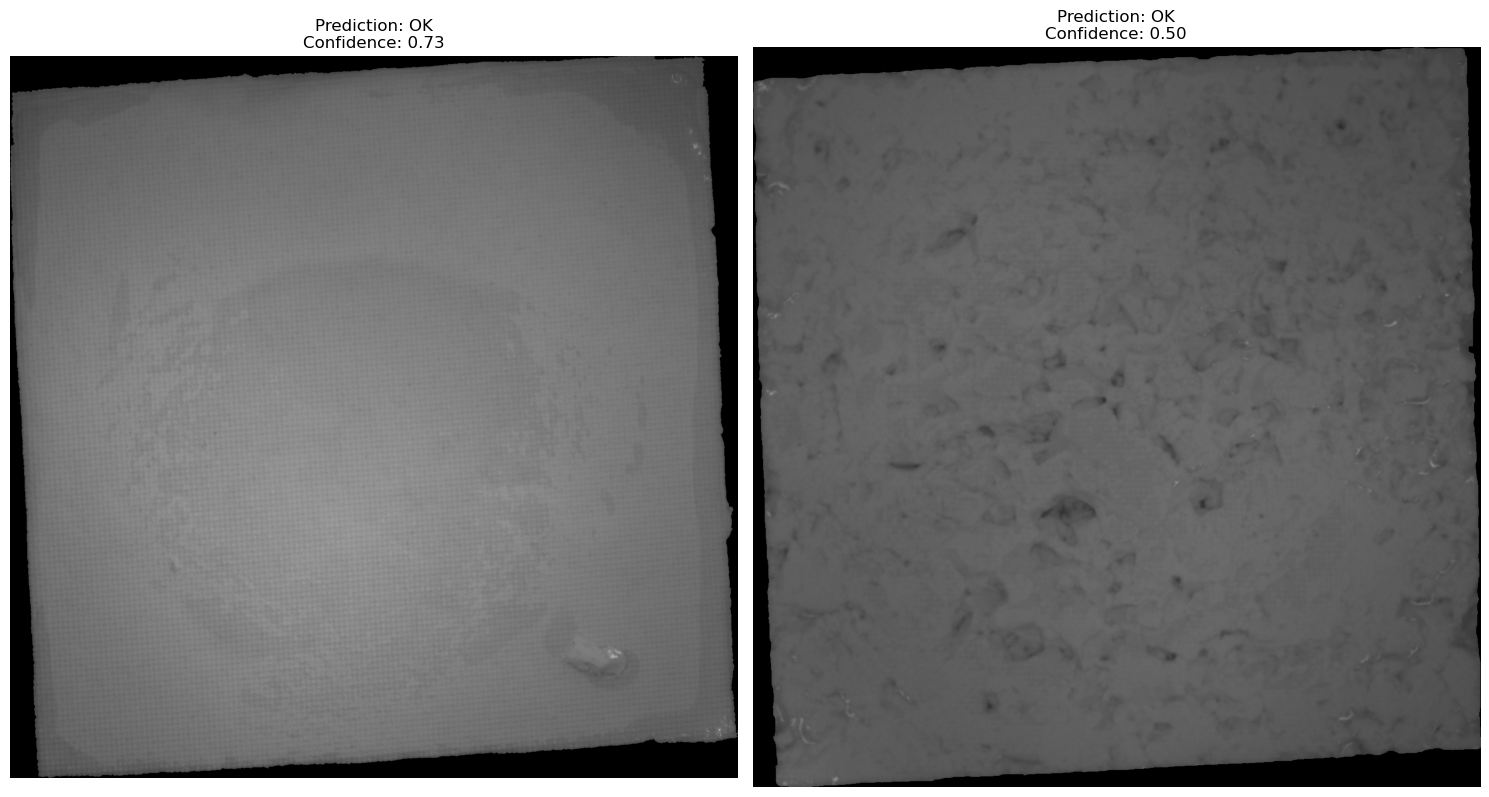

In [10]:
# 이미지 경로 리스트
image_paths = [
    "/home/ec2-user/SageMaker/data/Binary_PNG/test/OK/1034.png",
    "/home/ec2-user/SageMaker/data/Binary_PNG/test/NG/4853.png"
]

# 클래스 이름 (0: OK, 1: NG)
class_names = ["NG", "OK"]

# ResNet18 모델 시각화
visualize_predictions(model, image_paths, class_names)
